In [14]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import swifter
import perfplot
import matplotlib.pyplot as plt
import psutil

In [15]:
ncores = psutil.cpu_count()

In [16]:
ncores

12

In [17]:
npartitions = ncores * 2

# Read the data

In [18]:
data = pd.read_csv("status.csv")

In [19]:
data.head()

,station_id,bikes_available,docks_available,time
0,2,2,25,2013/08/29 12:06:01
1,2,2,25,2013/08/29 12:07:01
2,2,2,25,2013/08/29 12:08:01
3,2,2,25,2013/08/29 12:09:01
4,2,2,25,2013/08/29 12:10:01


In [20]:
data['date'] = pd.to_datetime(data['time'])

In [21]:
data.tail(50)

,station_id,bikes_available,docks_available,time,date
71984384,84,8,7,2015-08-31 23:10:02,2015-08-31 23:10:02
71984385,84,8,7,2015-08-31 23:11:02,2015-08-31 23:11:02
71984386,84,8,7,2015-08-31 23:12:02,2015-08-31 23:12:02
71984387,84,8,7,2015-08-31 23:13:03,2015-08-31 23:13:03
71984388,84,8,7,2015-08-31 23:14:02,2015-08-31 23:14:02
71984389,84,8,7,2015-08-31 23:15:02,2015-08-31 23:15:02
71984390,84,8,7,2015-08-31 23:16:02,2015-08-31 23:16:02
71984391,84,8,7,2015-08-31 23:17:02,2015-08-31 23:17:02
71984392,84,8,7,2015-08-31 23:18:02,2015-08-31 23:18:02
71984393,84,8,7,2015-08-31 23:19:02,2015-08-31 23:19:02


## vectorized function

In [22]:
def bike_proportion(x, max_x):   # x : data.bike_available, max_x = np.max(x)
    return x * 1.0 / max_x

In [23]:
bike_proportion(data['bikes_available'], np.max(data['bikes_available']))

0           0.074074
1           0.074074
2           0.074074
3           0.074074
4           0.074074
              ...   
71984429    0.296296
71984430    0.296296
71984431    0.296296
71984432    0.296296
71984433    0.296296
Name: bikes_available, Length: 71984434, dtype: float64

## non-vectorized function

In [24]:
def is_morning(datetime):
    if (datetime.hour >=6 ) and (datetime.hour < 12):
        return True
    else:
        return False

# use perfplot to compare the speed

In [25]:
vectorized_comparison = perfplot.bench(
    setup = lambda n: data.loc[:n, 'bikes_available'],
    kernels = [
        lambda df: df.apply(bike_proportion, max_x = np.max(data['bikes_available'])),
        lambda df: dd.from_pandas(df, npartitions = npartitions).map_partitions(bike_proportion,
            max_x = np.max(data['bikes_available']), meta=('f8')).compute(scheduler='threads'),
        lambda df: df.swifter.progress_bar(False).apply(bike_proportion, max_x=np.max(data['bikes_available'])),
        lambda df: bike_proportion(df, max_x = np.max(data['bikes_available']))
    ],
    labels = ['Pandas Apply', 'Dask Apply', 'Swifter Apply', 'Vectorized Function'],
    n_range = [2**k for k in range(0,28,2)],
    xlabel = 'n_rows'
)

Output()

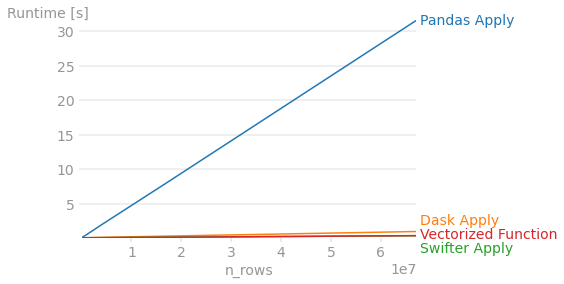

In [26]:
vectorized_comparison.plot(logx=False, logy=False)

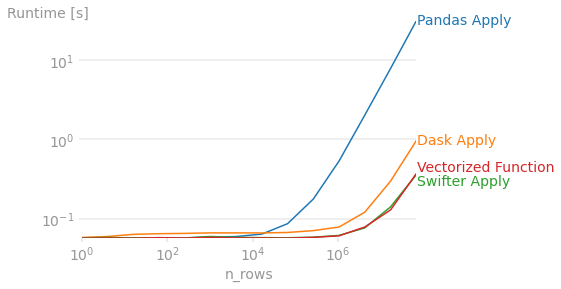

In [27]:
vectorized_comparison.plot()

# non-vectorized function speed comparison

In [28]:
nonvectorized_comparison = perfplot.bench(
    setup = lambda n: data.loc[:n, 'date'],
    kernels = [
        lambda df: df.apply(is_morning),
        lambda df: dd.from_pandas(df, npartitions = npartitions).apply(is_morning, meta=('bool')).compute(scheduler='processes'),
        lambda df: df.swifter.progress_bar(False).apply(is_morning)
        ],
    labels = ['Pandas Apply', 'Dask Apply', 'Swifter Apply', 'Vectorized Function'],
    n_range = [2**k for k in range(0,28,2)],
    xlabel = 'n_rows'
)

Output()

ZeroDivisionError: integer division or modulo by zero

In [35]:
X = np.linspace(0,4*np.pi,1000)
X

array([ 0.        ,  0.01257895,  0.0251579 ,  0.03773685,  0.0503158 ,
        0.06289475,  0.0754737 ,  0.08805265,  0.1006316 ,  0.11321055,
        0.1257895 ,  0.13836845,  0.15094739,  0.16352634,  0.17610529,
        0.18868424,  0.20126319,  0.21384214,  0.22642109,  0.23900004,
        0.25157899,  0.26415794,  0.27673689,  0.28931584,  0.30189479,
        0.31447374,  0.32705269,  0.33963164,  0.35221059,  0.36478954,
        0.37736849,  0.38994744,  0.40252639,  0.41510534,  0.42768429,
        0.44026323,  0.45284218,  0.46542113,  0.47800008,  0.49057903,
        0.50315798,  0.51573693,  0.52831588,  0.54089483,  0.55347378,
        0.56605273,  0.57863168,  0.59121063,  0.60378958,  0.61636853,
        0.62894748,  0.64152643,  0.65410538,  0.66668433,  0.67926328,
        0.69184223,  0.70442118,  0.71700013,  0.72957907,  0.74215802,
        0.75473697,  0.76731592,  0.77989487,  0.79247382,  0.80505277,
        0.81763172,  0.83021067,  0.84278962,  0.85536857,  0.86

In [36]:
Y = np.sin(X)

<ipython-input-38-c1c15029576d>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


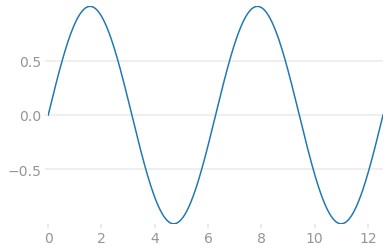

In [38]:
fig,ax = plt.subplots()
ax.plot(X,Y)
fig.show()

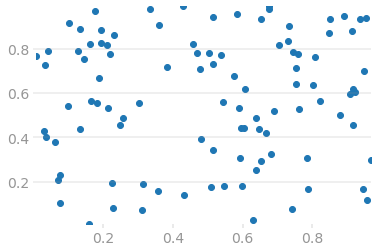

In [40]:
X = np.random.uniform(0,1,100)
Y = np.random.uniform(0,1,100)
plt.scatter(X,Y)

<BarContainer object of 10 artists>

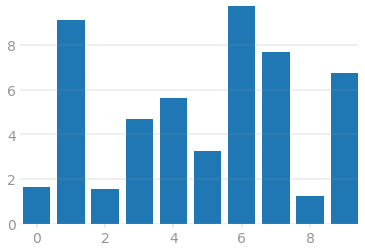

In [42]:
X = np.arange(10)
Y = np.random.uniform(1,10,10)
plt.bar(X,Y)

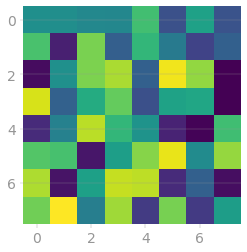

In [43]:
Z = np.random.uniform(0,1,(8,8))
plt.imshow(Z)

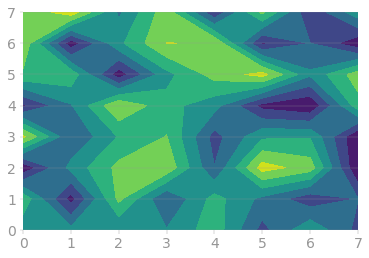

In [44]:
plt.contourf(Z)

In [46]:
Z = np.random.uniform(0,1,4)

([<matplotlib.patches.Wedge at 0x1c9857e7fa0>,
 [Text(0.7217625556058445, 0.8300956651647571, ''),
  Text(-0.9965089290705146, 0.4658003373579032, ''),
  Text(-0.2853316864747377, -1.0623492028017352, ''),
  Text(0.9430041182897189, -0.5663419752134129, '')])

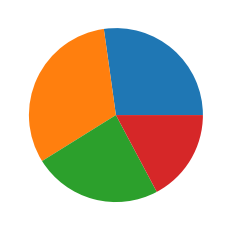

In [47]:
plt.pie(Z)

(array([ 1.,  1.,  8., 10., 19., 24., 17., 16.,  3.,  1.]),
 array([-3.42646512, -2.79021496, -2.1539648 , -1.51771465, -0.88146449,
        -0.24521433,  0.39103583,  1.02728599,  1.66353615,  2.2997863 ,
         2.93603646]),
 <BarContainer object of 10 artists>)

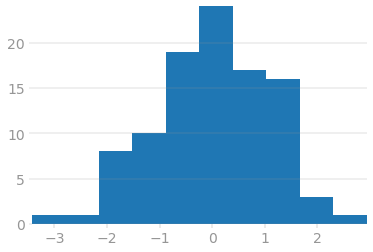

In [48]:
Z = np.random.normal(0,1,100)
plt.hist(Z)

<ErrorbarContainer object of 3 artists>

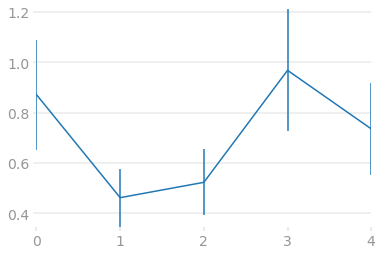

In [49]:
X = np.arange(5)
Y = np.random.uniform(0,1,5)
plt.errorbar(X,Y,Y/4)

{'whiskers': [<matplotlib.lines.Line2D at 0x1c98568ab20>,
 'caps': [<matplotlib.lines.Line2D at 0x1c98567f220>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c98568a7c0>,
 'medians': [<matplotlib.lines.Line2D at 0x1c98567f8e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c98567fc40>,
 'means': []}

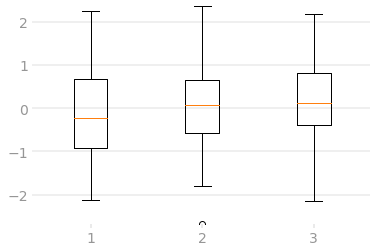

In [50]:
Z = np.random.normal(0,1,(100,3))
plt.boxplot(Z)

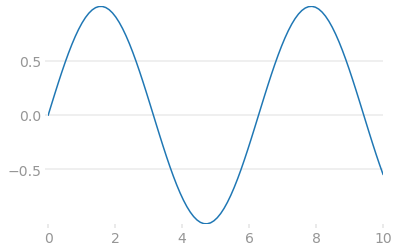

In [51]:
X = np.linspace(0,10,100)
Y = np.sin(X)
plt.plot(X,Y)

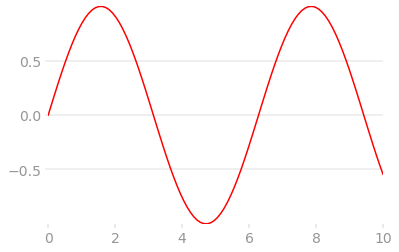

In [52]:
plt.plot(X,Y,color="red")

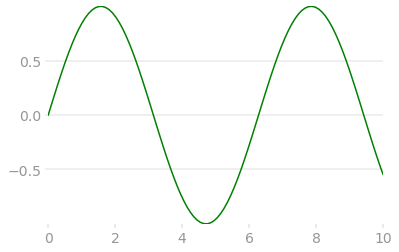

In [53]:
plt.plot(X,Y,color="green")

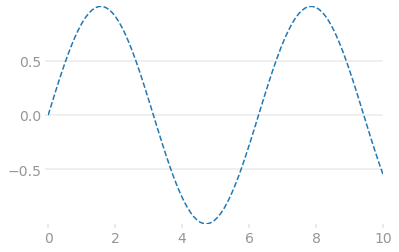

In [54]:
plt.plot(X,Y,linestyle="--")

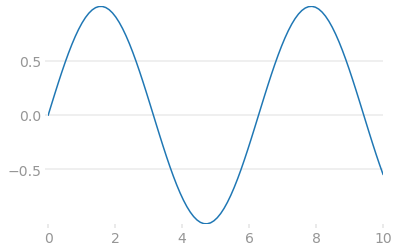

In [55]:
plt.plot(X,Y,linestyle="-")

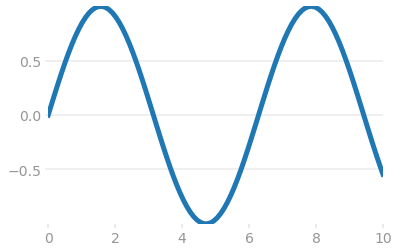

In [56]:
plt.plot(X,Y,linewidth=5)

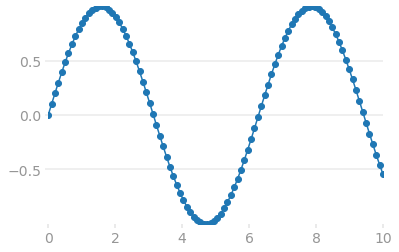

In [57]:
plt.plot(X,Y,marker="o")

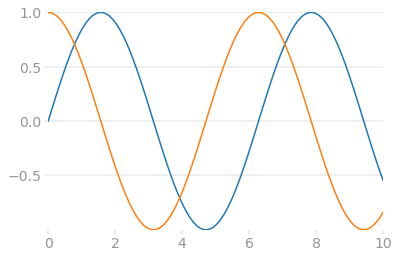

In [60]:
X = np.linspace(0,10,100)
Y1, Y2 = np.sin(X), np.cos(X)
plt.plot(X,Y1,X,Y2)

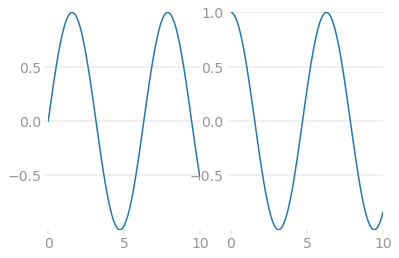

In [64]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(X,Y1)
ax2.plot(X,Y2)

Text(0.5, 0, 'Time')

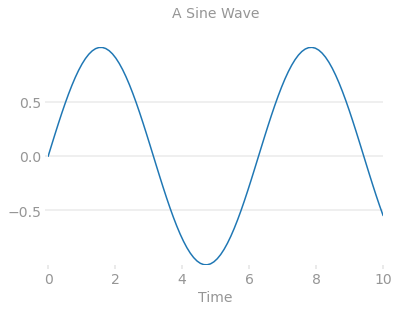

In [67]:
fig, ax = plt.subplots()
ax.plot(X,Y)
fig.suptitle(None)
ax.set_title("A Sine Wave")
ax.set_xlabel("Time")

In [68]:
fig.savefig("testing_save.png", dpi=400)

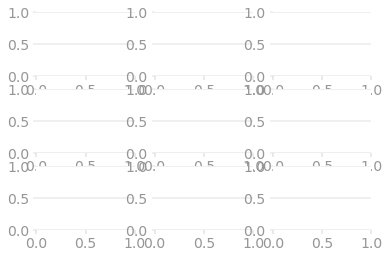

In [70]:
fig, axs = plt.subplots(3,3)

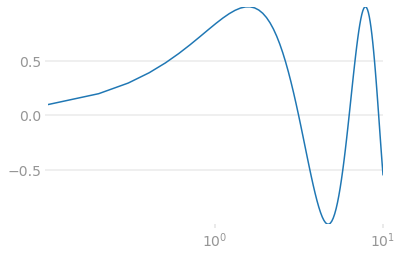

In [72]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.plot(X,Y)

# Seaborn

In [73]:
import seaborn as sns

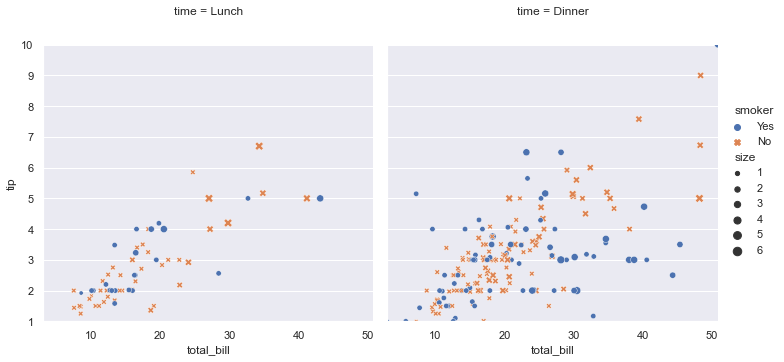

In [78]:
sns.set_theme()

tips = sns.load_dataset("tips")

sns.relplot(
    data = tips,
    x = "total_bill", y = "tip", col="time",
    hue = "smoker", style="smoker", size="size")

In [79]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


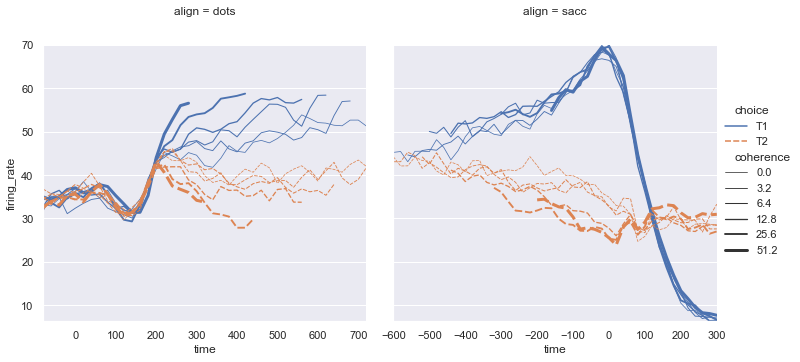

In [80]:
dot = sns.load_dataset("dots")
sns.relplot(
    data=dot, kind="line",
    x = "time", y="firing_rate", col="align",
    hue="choice", size="coherence", style="choice",
    facet_kws=dict(sharex=False))

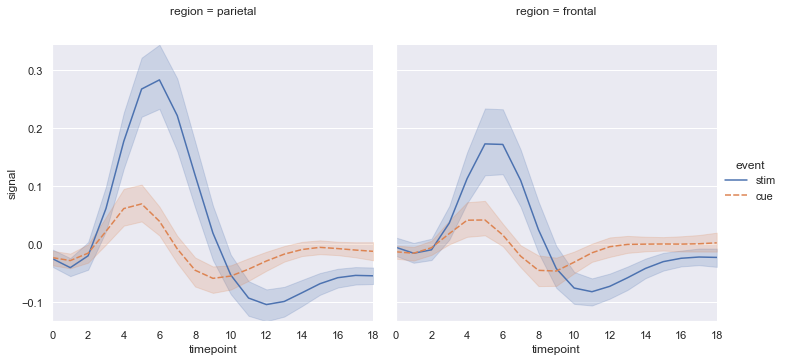

In [81]:
fmri = sns.load_dataset("fmri")
sns.relplot(
    data=fmri, kind="line",
    x = "timepoint", y="signal", col="region",
    hue="event", style="event")

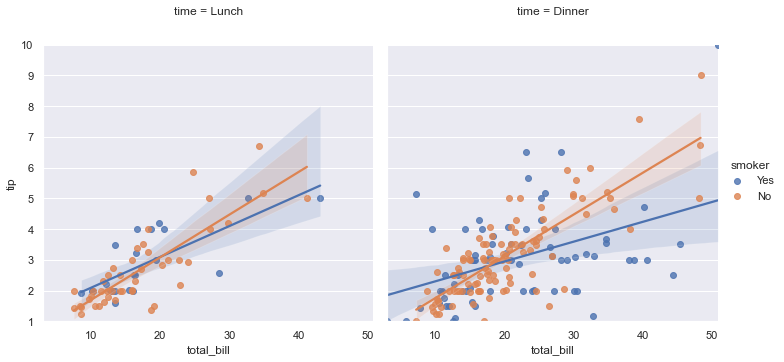

In [82]:
sns.lmplot(data=tips,x="total_bill",y="tip",col='time', hue='smoker')

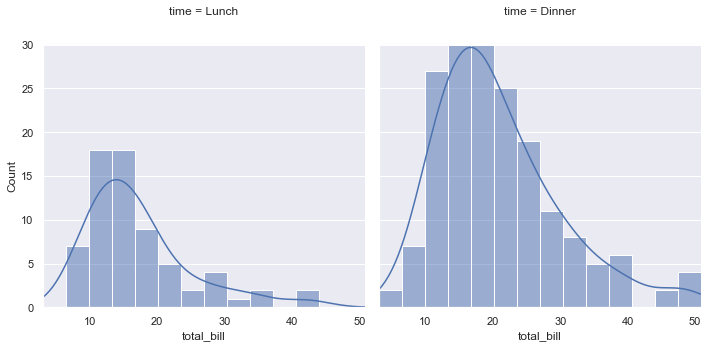

In [83]:
sns.displot(data=tips,x="total_bill",col="time", kde=True)

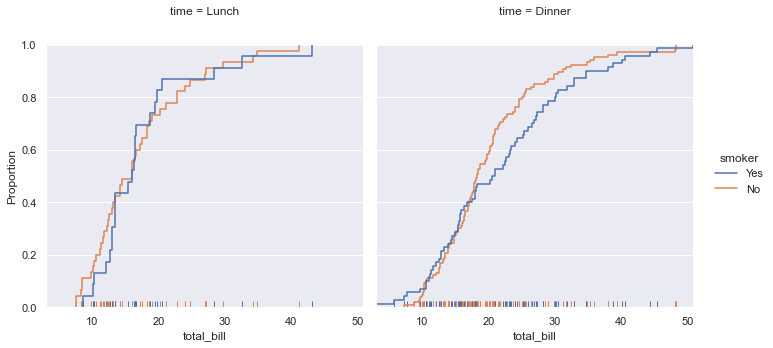

In [85]:
sns.displot(data=tips,kind="ecdf",x='total_bill',col="time",hue="smoker", rug=True)

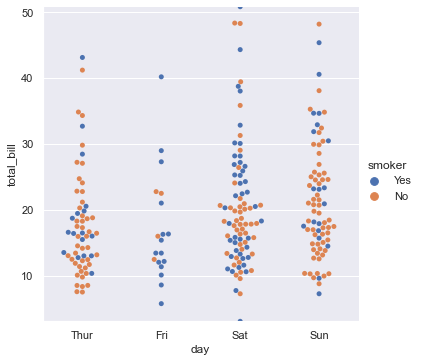

In [86]:
sns.catplot(data=tips, kind="swarm",x="day",y="total_bill",hue="smoker")

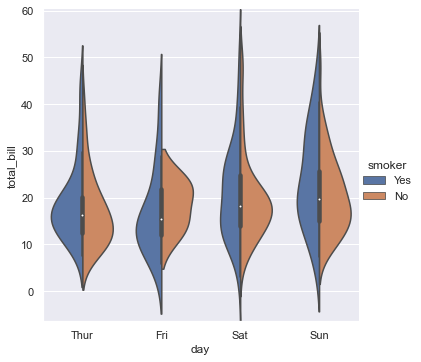

In [87]:
sns.catplot(data=tips, kind="violin",x="day",y="total_bill",hue="smoker",split=True)

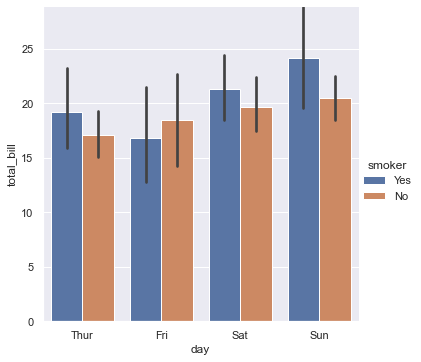

In [88]:
sns.catplot(data=tips, kind="bar",x="day",y="total_bill",hue="smoker")

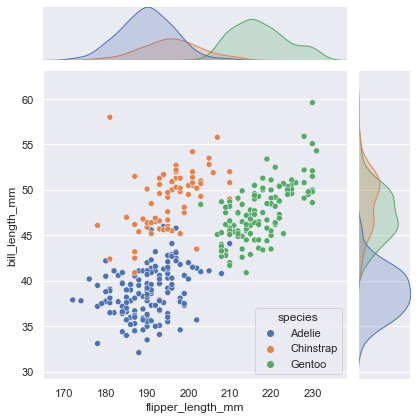

In [89]:
penguins = sns.load_dataset("penguins")
sns.jointplot(data=penguins, x="flipper_length_mm", y="bill_length_mm",hue="species")

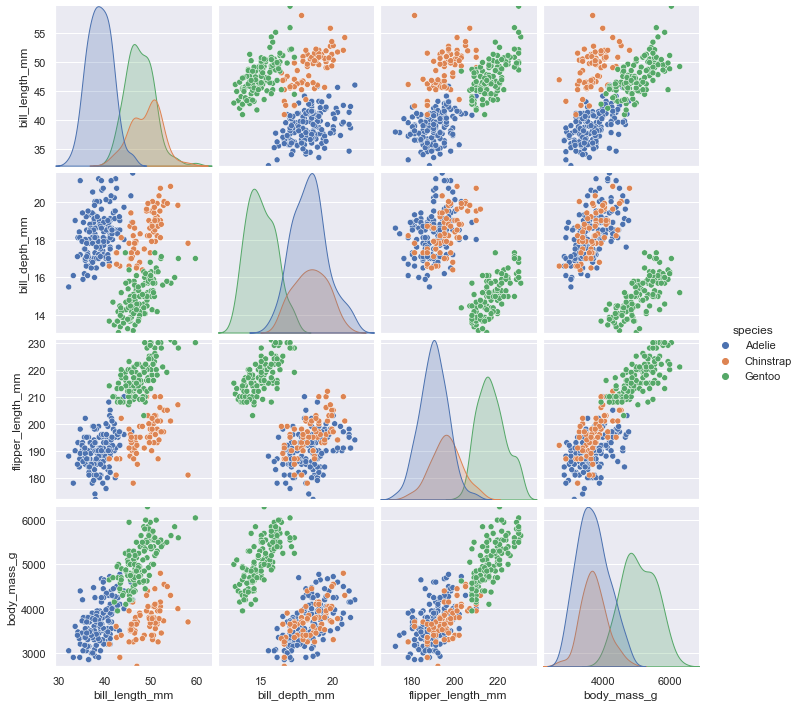

In [90]:
sns.pairplot(data=penguins,hue="species")

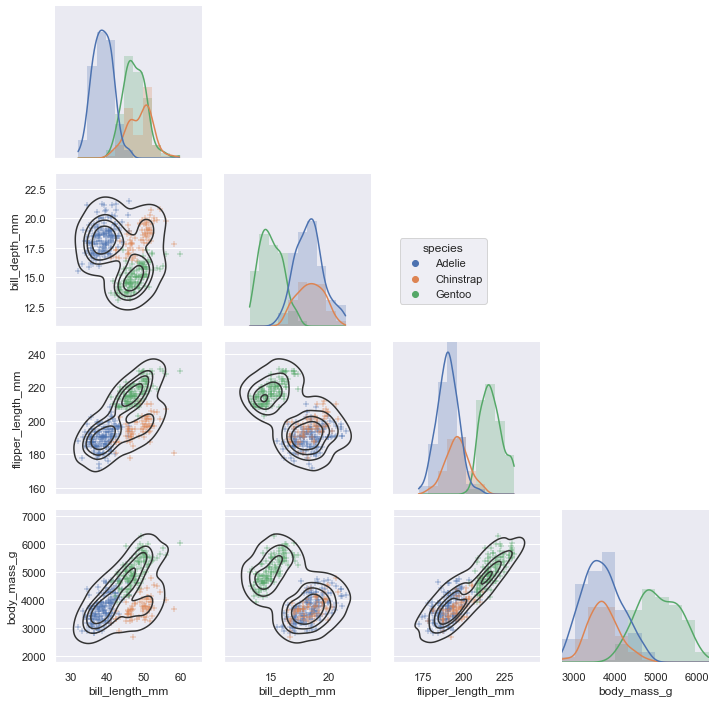

In [92]:
g = sns.PairGrid(penguins, hue="species",corner=True)
g.map_lower(sns.kdeplot, hue=None,levels=5,color=".2")
g.map_lower(sns.scatterplot, marker="+")
g.map_diag(sns.histplot, element="step", linewidth=0,kde=True)
g.add_legend(frameon=True)
g.legend.set_bbox_to_anchor((.61,.6))